<a href="https://colab.research.google.com/github/PGLavergne/NYTCrosswordPredicter/blob/main/Project_Part_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/PGLavergne/NYTCrosswordPredicter/main/nytcrosswords.csv'
dataSet = pd.read_csv(url, encoding='latin-1')
dataSet_partial = pd.read_csv(url, encoding='latin-1', nrows=3000)
dataSet

,Date,Word,Clue
0,10/31/2021,PAT,"Action done while saying ""Good dog"""
1,10/31/2021,RASCALS,Mischief-makers
2,10/31/2021,PEN,It might click for a writer
3,10/31/2021,SEP,Fall mo.
4,10/31/2021,ECO,Kind to Mother Nature
...,...,...,...
781568,11/21/1993,NAT,Actor Pendleton
781569,11/21/1993,SHRED,Bit
781570,11/21/1993,NEA,Teachers' org.
781571,11/21/1993,BEG,Petition


The code below will initialize the GPT2 model and tokenizer from Hugging Face. It will train the model and and allow the user to input a clue and generate a predicted word.

Epoch 1/3:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/21 [00:00<?, ?it/s]

Enter the clue: Studio Fixtures
Enter the character size of the answer: 6


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Predicted word based on the clue 'Studio Fixtures' and character size 6: Studio Fixtures
10/


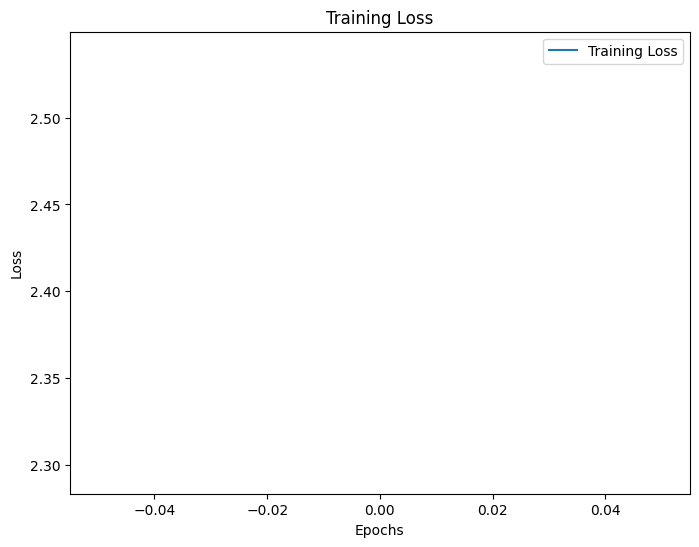

In [10]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt


tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')

#my dataset
file_path = 'partial_dataset.csv'
dataset = TextDataset(tokenizer=tokenizer, file_path=file_path, block_size=128)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_batch_size = 20
epochs = 3
learning_rate = 5e-5

train_loader = DataLoader(dataset, batch_size=train_batch_size, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []

#this code (that I got help creating from ChatGPT) checks if GPU is available
#and uses it, if so. Greatly reduced runtime.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        batch = batch.to(device)
        outputs = model(input_ids=batch, labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

model.eval()

input_clue = input("Enter the clue: ")
input_size = int(input("Enter the character size of the answer: "))

input_encoded = tokenizer(input_clue, return_tensors='pt', padding=True, truncation=True)

#generates prediction
generated = model.generate(
    input_ids=input_encoded['input_ids'].to(model.device),
    attention_mask=input_encoded['attention_mask'].to(model.device),
    max_length=input_size,
    num_return_sequences=1
)

decoded_output = tokenizer.decode(generated[0], skip_special_tokens=True)
print(f"Predicted word based on the clue '{input_clue}' and character size {input_size}: {decoded_output}")

train_loss = total_loss / len(train_loader)
train_losses.append(train_loss)

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Not only is the training loss not being mapped, but the predictive model is totally off base when it comes to understanding the limitations in it's character scope.